In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sys

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

sys.path.insert(1, '..')

from repsys.dataset import Dataset, dtypes
from repsys.model import ScikitModel

In [9]:
class MovieLens(Dataset):
  def name(self):
    return "movielens"

  def get_genres(self):
    return self.tags['genres']

  def item_dtypes(self):
    return {
        "movieId": dtypes.ItemID(),
        "title": dtypes.String(),
        "genres": dtypes.Tags(sep="|"),
    }

  def item_mappings(self):
    return {
      "caption": lambda df: df['genres'].str.replace('|', ', ', regex=False),
      "subtitle": lambda df: df['title'].str.extract('\((\d+)\)'),
    }

  def interact_dtypes(self):
    return {
        "movieId": dtypes.ItemID(),
        "userId": dtypes.UserID(),
        "rating": dtypes.Rating(min=0.5, step=0.5),
    }

  def load_items(self):
    return pd.read_csv("./ml-20m/movies.csv")

  def load_interacts(self):
    return pd.read_csv("./ml-20m/ratings.csv")

In [10]:
dataset = MovieLens()
# dataset.fit()

In [10]:
dataset.save('./ml-20m/dump.zip')

In [11]:
dataset.load('./ml-25m/dump.zip')

In [13]:
dataset.item_title()

TypeError: item_title() missing 1 required positional argument: 'items'

In [10]:
user_id = dataset.vad_users[0]
print(user_id)

81910


In [14]:
user_idx = dataset.get_user_index(user_id)
print(user_idx)

0


In [15]:
user_interacts = dataset.vad_data_tr[user_idx].toarray()

In [16]:
user_interacts

array([[0., 0., 0., ..., 0., 0., 0.]])

In [17]:
item_idxs = np.argwhere(user_interacts == 1)[:, 1]

In [18]:
item_idxs

array([   39,    89,   101,   121,   208,   212,   226,   492,   612,
         729,   765,   793,  1005,  1017,  1337,  1462,  1810,  1940,
        2211,  2724,  4030,  4202,  4594,  4603,  4623,  5819,  6223,
        7172, 10018, 11629, 12177, 12403])

In [21]:
item_ids = np.array([dataset.get_item_id(idx) for idx in item_idxs])

In [23]:
item_ids

array([ 1653,  5952,  8360,   296,  6016,  6377,  7361,   307,  1088,
        2692,  3448,  4973,  4144,  8327,  5878,   665,  2843, 27266,
        1237,  6370,  7234,  8786,  2351,  4325,  8154,  7209,  3569,
        7365,  2632,  2573,  7940,  5767])

In [24]:
dataset.items.loc[item_ids]

,title,genres
movieId,,
1653,Gattaca (1997),Drama|Sci-Fi|Thriller
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
8360,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1088,Dirty Dancing (1987),Drama|Musical|Romance


In [60]:
class KNN(ScikitModel):
  def __init__(self, k=5):
    self.model = NearestNeighbors(n_neighbors=k, metric="cosine")

  def name(self):
    return "KNN"

  def fit(self):
    self.model.fit(self.dataset.train_data)

  def predict(self, X, **kwargs):
    distances, indexes = self.model.kneighbors(X)

    print("-> Distances computed")

    n_distances = distances[:, 1:]
    n_indexes = indexes[:, 1:]

    n_distances = 1 - n_distances

    sums = n_distances.sum(axis=1)
    n_distances = n_distances / sums[:, np.newaxis]

    print("-> Distances normalized")

    predictions = np.array(
        [
            self.dataset.train_data[idx]
            .multiply(dist.reshape(-1, 1))
            .sum(axis=0)
            for idx, dist in zip(n_indexes, n_distances)
        ]
    ).squeeze(axis=1)

    print("-> Predictions completed")

    predictions[X.toarray() > 0] = 0

    print("-> History erased")

    return predictions

In [61]:
class SVDKNN(KNN):
  def __init__(self, svd_components=20):
    super().__init__()
    self.svd = TruncatedSVD(n_components=svd_components, algorithm='arpack')

  def name(self):
    return "SVDKNN"

  def fit(self):
    self.train_embed = self.svd.fit_transform(self.dataset.train_data)
    self.model.fit(self.train_embed)

  def predict(self, X, **kwargs):
    X_embed = self.svd.transform(X)
    return super().predict(X_embed, **kwargs)

In [62]:
model = KNN()
model.update_data(dataset)
model.fit()

In [63]:
model_svd = SVDKNN()
model_svd.update_data(dataset)
model_svd.fit()

In [66]:
dataset.vad_data_tr.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [67]:
X_pred = model.predict(dataset.vad_data_tr)

-> Distances computed
-> Distances normalized
-> Predictions completed
-> History erased


In [65]:
evaluator = repsys.ModelEvaluator()

In [66]:
evaluator.evaluate_model(model, dataset.vad_data_tr, dataset.vad_data_te)

-> Distances computed
-> Distances normalized
-> Predictions completed
-> History erased


In [67]:
evaluator.evaluate_model(model_svd, dataset.vad_data_tr, dataset.vad_data_te)

-> Embeddings computed
-> Distances computed
-> Distances normalized
-> Predictions completed
-> History erased


In [68]:
evaluator.print_results()

Model: KNN
Recall@5=0.20815 (0.00231)
Recall@20=0.27001 (0.00243)
Recall@50=0.34642 (0.00261)
NCDG@100=0.27934 (0.00199)
-------------
Model: KNNSVD
Recall@5=0.19059 (0.00221)
Recall@20=0.24020 (0.00228)
Recall@50=0.32399 (0.00256)
NCDG@100=0.26354 (0.00196)


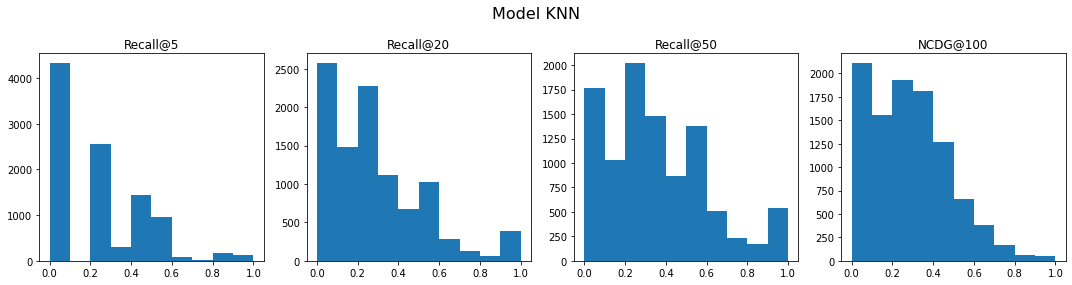

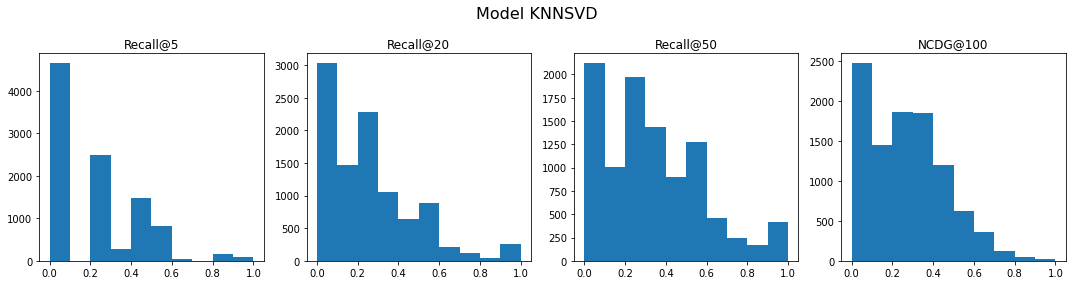

In [69]:
evaluator.plot_distributions()

In [70]:
import bottleneck as bn

In [71]:
def recall(X_pred, heldout_batch, k=100):
  batch_users = X_pred.shape[0]

  idx = bn.argpartition(-X_pred, k, axis=1)
  X_pred_binary = np.zeros_like(X_pred, dtype=bool)
  X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

  X_true_binary = (heldout_batch > 0).toarray()
  tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
      np.float32
  )
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
  return recall

In [73]:
recall(X_pred, dataset.vad_data_te).mean()

0.3642179658302286